In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# 设置随机种子，保证结果可复现
np.random.seed(42)

# 定义参数
n_samples = 10000  # 总样本数
n_features = 500   # 特征维度
train_size = 7000  # 训练集大小
test_size = 3000   # 测试集大小
noise_std = 0.1

# 生成特征数据 X (服从均匀分布或正态分布，这里选择正态分布)
# X = np.random.randn(n_samples, n_features)  # 形状为 (10000, 500)
X = np.random.randn(n_samples, n_features).astype(np.float32)

# 生成误差项 epsilon (服从均值为0的正态分布)
# epsilon = np.random.randn(n_samples)
epsilon = np.random.randn(n_samples).astype(np.float32) * noise_std

# 计算目标值 y，根据公式 y = 0.028 + sum(0.0056 * x_i) + epsilon
# 先计算特征的线性组合部分
linear_combination = 0.0056 * np.sum(X, axis=1)  # 对每行特征求和后乘以系数
y = 0.028 + linear_combination + epsilon  # 加上偏置项和误差项

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42  # 固定随机状态，确保划分一致
)


print(f"数据集生成完成：")
print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")

数据集生成完成：
训练集形状: X=(7000, 500), y=(7000,)
测试集形状: X=(3000, 500), y=(3000,)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 数据准备
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义神经网络模型 - 与从零实现相同的结构
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # 输入层到隐藏层
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim) # 隐藏层到输出层
        
    def forward(self, x):
        # 隐藏层计算
        z1 = self.fc1(x)
        a1 = self.relu(z1)
        a1_dropout = self.dropout(a1)  # 仅在训练时应用
        
        # 输出层计算
        z2 = self.fc2(a1_dropout)
        return z2

# 初始化模型
input_dim = 500
hidden_dim =128
output_dim = 1
dropout_rate = 0.3  # 与从零实现相同的dropout率

model = FeedForwardNet(input_dim, hidden_dim, output_dim, dropout_rate).to(device)
print("网络结构:")
print(model)

# 定义损失函数和优化器 - 使用与从零实现相同的超参数
criterion = nn.MSELoss()
# 使用SGD优化器而不是Adam，学习率0.001，与从零实现相同
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)  # 与从零实现相同的L2正则化系数

# 移除学习率调度器，因为从零实现中没有使用
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 训练函数 - 使用与从零实现相同的早停参数
def train_model(model, train_loader, test_loader, epochs=500):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20  # 与从零实现相同的早停耐心值
    patience_counter = 0
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # 前向传播
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        # 计算平均训练损失
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 评估模式
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                test_loss += loss.item() * batch_X.size(0)
        
        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        
        # 移除学习率调度步骤
        # scheduler.step(test_loss)
        
        # 早停机制 - 与从零实现相同
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        # 打印训练进度 - 每10个epoch打印一次，与从零实现相同
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
        
            # 检查早停 - 与从零实现相同
            if patience_counter >= patience:
                print(f'早停触发，在第 {epoch+1} 个epoch停止训练')
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, test_losses

# 训练模型
print("开始训练...")
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=1000)


使用设备: cuda
网络结构:
FeedForwardNet(
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
开始训练...
Epoch [10/1000], Train Loss: 0.047853, Test Loss: 0.037159
Epoch [20/1000], Train Loss: 0.033024, Test Loss: 0.029121
Epoch [30/1000], Train Loss: 0.027438, Test Loss: 0.025901
Epoch [40/1000], Train Loss: 0.024943, Test Loss: 0.024439
Epoch [50/1000], Train Loss: 0.023523, Test Loss: 0.023668
Epoch [60/1000], Train Loss: 0.022618, Test Loss: 0.023188
Epoch [70/1000], Train Loss: 0.021852, Test Loss: 0.022836
Epoch [80/1000], Train Loss: 0.021577, Test Loss: 0.022549
Epoch [90/1000], Train Loss: 0.021391, Test Loss: 0.022254
Epoch [100/1000], Train Loss: 0.020947, Test Loss: 0.021958
Epoch [110/1000], Train Loss: 0.020772, Test Loss: 0.021658
Epoch [120/1000], Train Loss: 0.020755, Test Loss: 0.021336
Epoch [130/1000], Train Loss: 0.019711, Test Loss: 0.021032
Epoc

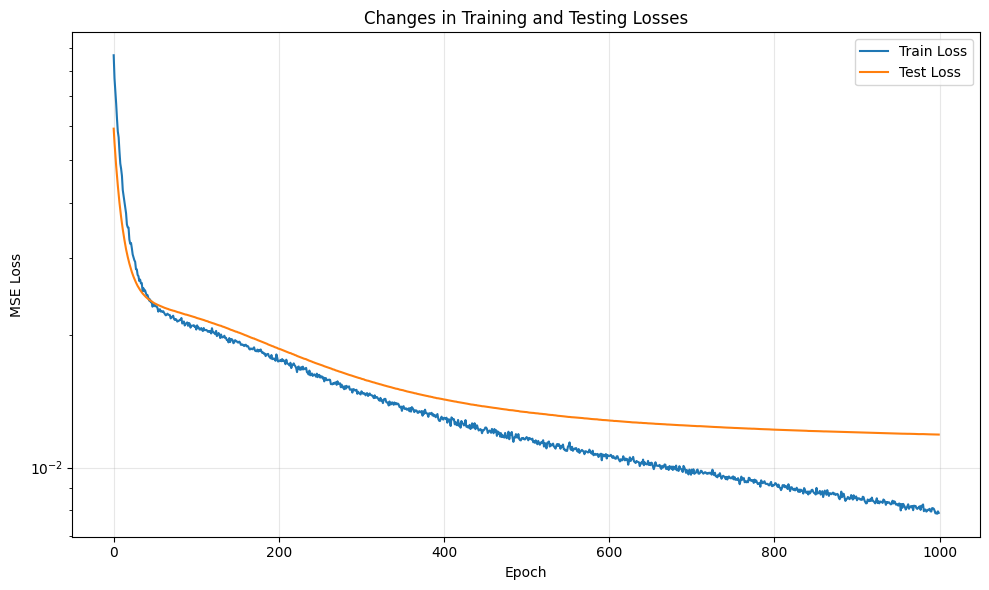

最终训练集MSE: 0.006603
最终测试集MSE: 0.011886


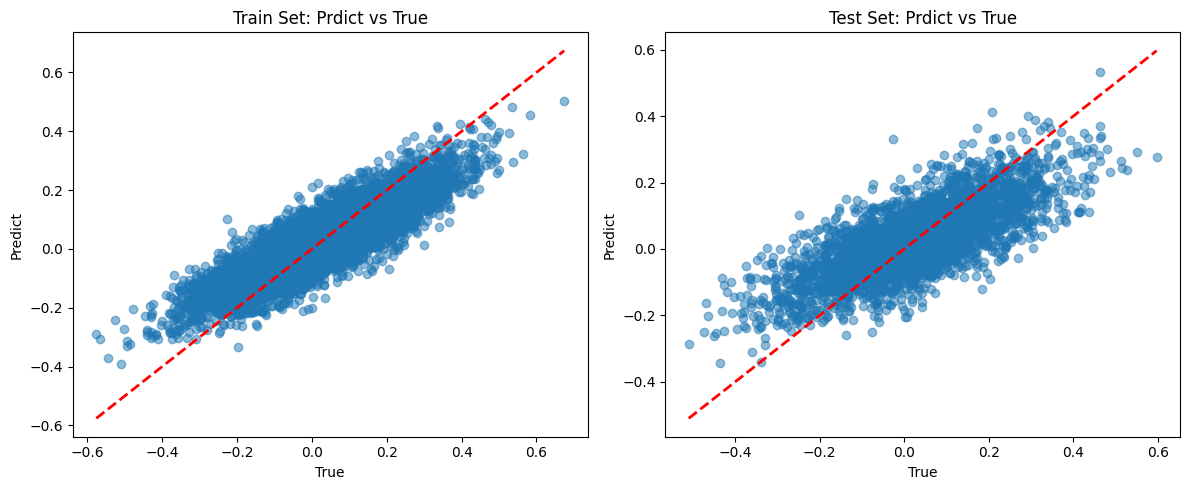

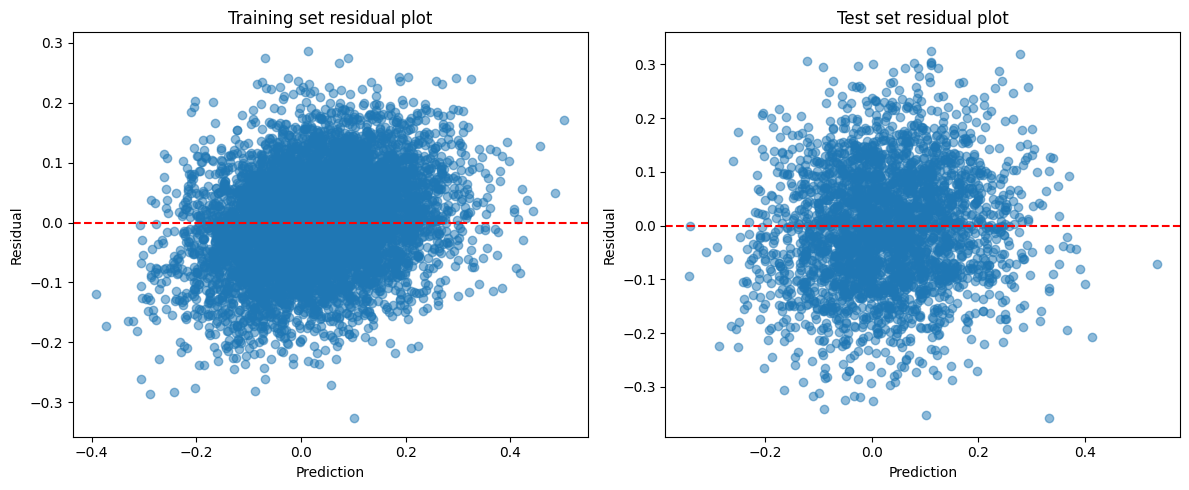

训练集残差统计: 均值=0.000026, 标准差=0.081262
测试集残差统计: 均值=-0.004334, 标准差=0.108936


In [3]:
# 绘制训练和测试损失
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Changes in Training and Testing Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# 最终评估
model.eval()
with torch.no_grad():
    # 训练集预测
    y_train_pred = model(X_train_tensor).cpu().numpy().flatten()
    train_mse = mean_squared_error(y_train, y_train_pred)
    
    # 测试集预测
    y_test_pred = model(X_test_tensor).cpu().numpy().flatten()
    test_mse = mean_squared_error(y_test, y_test_pred)

print(f"最终训练集MSE: {train_mse:.6f}")
print(f"最终测试集MSE: {test_mse:.6f}")

# 绘制预测值与真实值的散点图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train Set: Prdict vs True')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Test Set: Prdict vs True')

plt.tight_layout()
plt.show()

# 残差分析
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Training set residual plot')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Test set residual plot')

plt.tight_layout()
plt.show()

print(f"训练集残差统计: 均值={np.mean(train_residuals):.6f}, 标准差={np.std(train_residuals):.6f}")
print(f"测试集残差统计: 均值={np.mean(test_residuals):.6f}, 标准差={np.std(test_residuals):.6f}")